# **Statistical Tests**

## Objectives

* Perform distribution checks on the data
* Test project hypotheses through statistical tests

## Inputs

* Cleaned data from ETL pipeline

## Outputs

* Outputs are all contained within the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Import Data and Load Packages

Load packages required to run the notebook

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
import statsmodels.formula.api as smf
sns.set_style('whitegrid')

Import cleaned data produced by the ETL pipeline

In [44]:
# *Import raw data for testing
# Import cleaned data from ETL pipeline into dataframe

df = pd.read_csv("../data/insurance-cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1337 non-null   int64  
 1   sex           1337 non-null   object 
 2   bmi           1337 non-null   float64
 3   children      1337 non-null   int64  
 4   smoker        1337 non-null   int64  
 5   region        1337 non-null   int64  
 6   charges       1337 non-null   float64
 7   bmi_category  1337 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 83.7+ KB


Convert data types for categorical variables so that they are handled correctly in the code

In [ ]:
# convert smoker and region values from number to string
df['smoker'] = df['smoker'].apply(str)
df['region'] = df['region'].apply(str)
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,1,3,16884.92400,Overweight
1,18,male,33.770,1,0,2,1725.55230,Obese
2,28,male,33.000,3,0,2,4449.46200,Obese
3,33,male,22.705,0,0,1,21984.47061,Normal
4,32,male,28.880,0,0,1,3866.85520,Overweight


---

# Initial Visualisations and Distribution Checks

Create simple visulisations for categorical variables

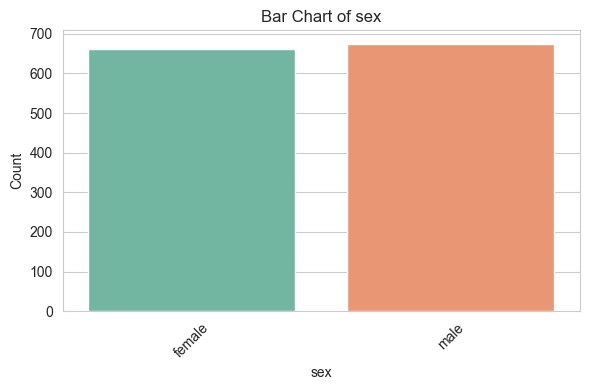

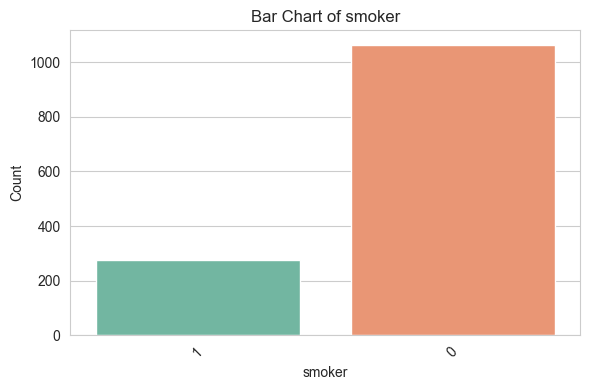

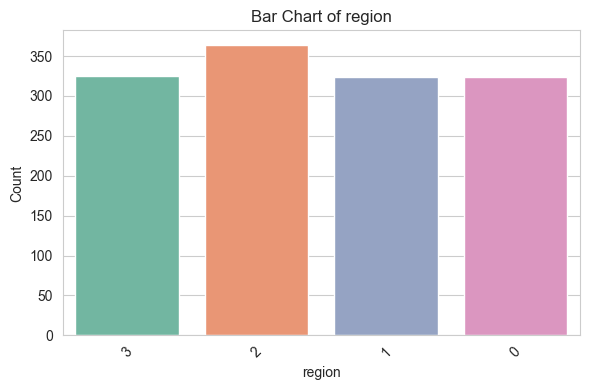

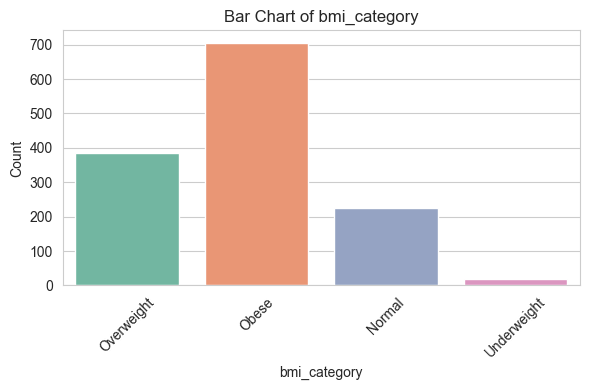

In [27]:
# create a dataframe of categorical columns
df_cat = df.select_dtypes(include='object')

# Loop through each categorical column
for col in df_cat:
    counts = df_cat[col].value_counts()
    
    # ---- Bar chart ----
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df_cat, hue=col, palette="Set2")
    plt.title(f"Bar Chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

From these charts we can see that the split of data across different regions and by sex is roughly equal.<br>
BMI category and smoker status are less balanced and we may not be able to accurately predict charges for underrepresented groups in these categories.

Create a histogram of numerical data to visualise distributions

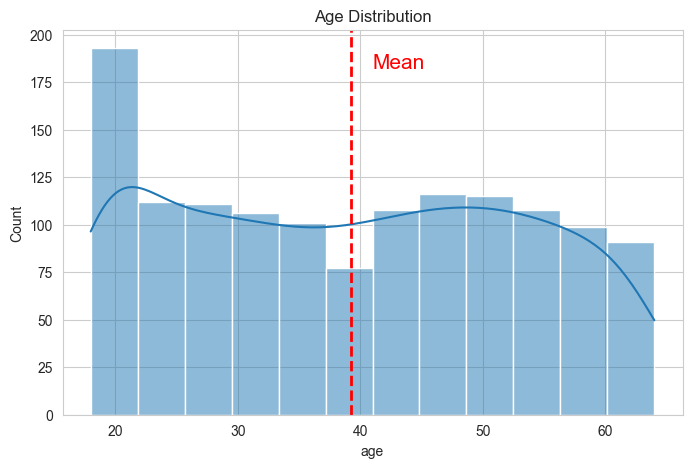

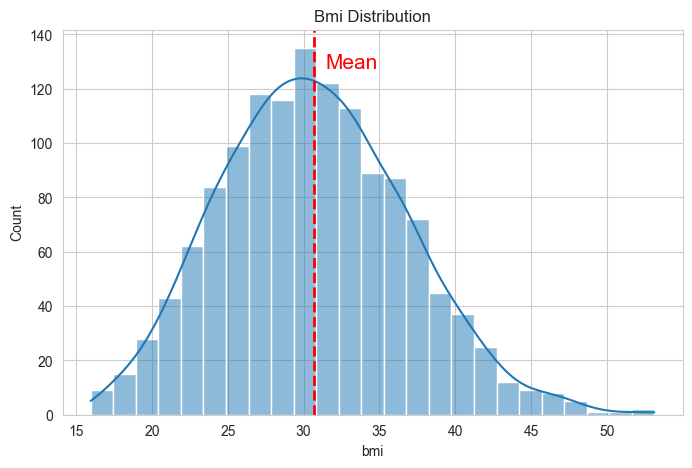

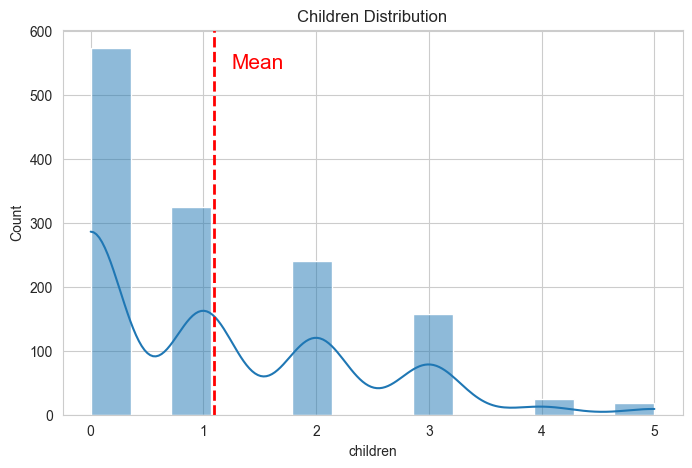

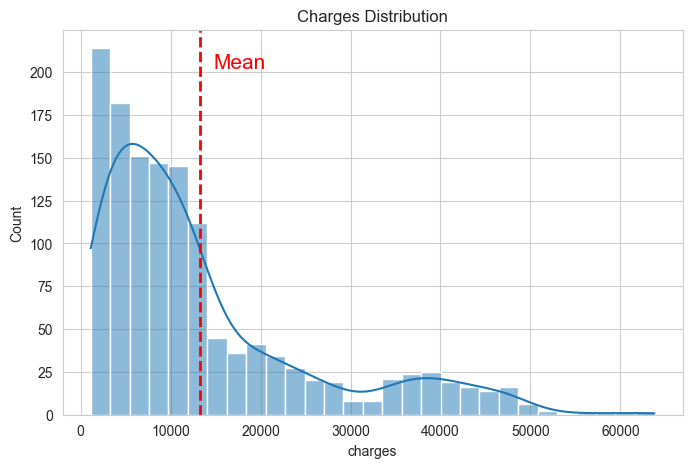

In [29]:
# create a dataframe of only numeric columns
df_num = df.select_dtypes(include=[np.number])

# loop through numeric columns and create a distribution chart for each
for col in df_num.columns:
  fig, axes = plt.subplots(figsize=(8,5))
  plt.title(f"{col.capitalize()} Distribution")
  sns.histplot(data=df_num, x=col, kde=True)
  plt.axvline(df_num[col].mean(), color='r', linestyle='dashed', linewidth=2)
  plt.text(x=df_num[col].mean() + df_num[col].std()/8 , y=axes.get_ylim()[1] * 0.90, s='Mean', fontsize=15, c='r') # offset mean label
  plt.show()
  print("\n")


Age appears to have a fairly uniform distribution in this dataset.<br>
BMI looks normally distributed<br>
Number of children and Insurance charges are both positively skewed

In [ ]:
# check skewness of columns

df_num.skew()

age         0.054781
bmi         0.283914
children    0.937421
charges     1.515391
dtype: float64

In [34]:
# check data for normality

pg.normality(data=df, alpha=0.05)

,W,pval,normal
age,0.944856,6.210453e-22,False
bmi,0.993876,2.575293e-05,False
children,0.823397,5.404484e-36,False
charges,0.814761,1.195974e-36,False


## Distribution of Charges by Category

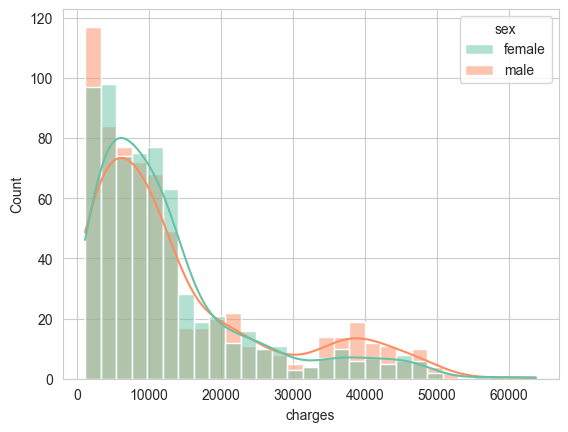

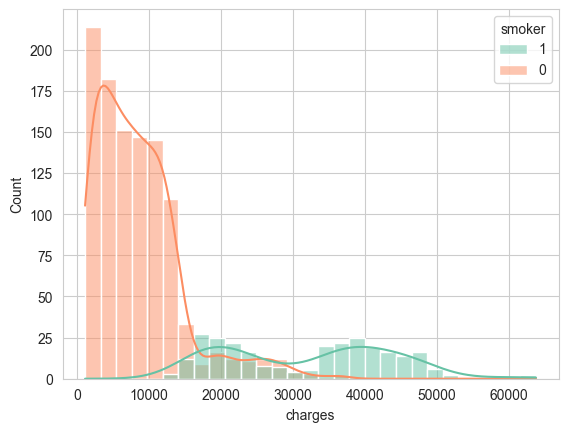

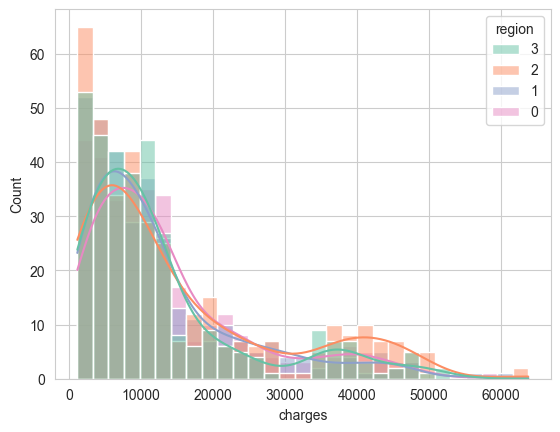

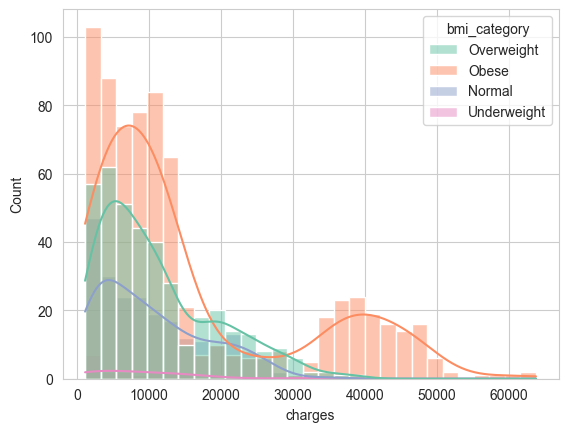

In [36]:
for col in df_cat:
    sns.histplot(data=df, x='charges',hue=col , kde=True, palette='Set2')
    plt.show()
    print("\n\n")

Coninuous variables by charge (y = charge)

---

## Hypothesis Testing

* H1: Smokers will have higher insurance charges than non-smokers
* H2: Charges will be positively correlated with BMI
* H3: Charges will be positively correlated with age
* H4: Children effect
* H5: Region effect
* H6: Gender effect
* H7: BMI x Smoker interaction

In [38]:
# --------------------------------------------
# Effect size helpers (adapted for non-parametric context)
# --------------------------------------------

# For Mann-Whitney U tests, use rank-biserial correlation as an effect size
def rank_biserial(x, y):
    u, _ = stats.mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    rbc = 1 - (2 * u) / (n1 * n2)
    return rbc

def interpret_rbc(r):
    if abs(r) < 0.1:
        return "very small"
    elif abs(r) < 0.3:
        return "small"
    elif abs(r) < 0.5:
        return "medium"
    else:
        return "large"

# For Kruskal–Wallis (eta squared alternative)
def interpret_eta2(eta2):
    if eta2 < 0.01:
        return "very small"
    elif eta2 < 0.06:
        return "small"
    elif eta2 < 0.14:
        return "medium"
    else:
        return "large"

### Hypothesis One

Smokers vs Non-Smokers (Mann–Whitney U)

In [45]:
# --------------------------------------------
# Ensure smoker_flag exists for later use
# --------------------------------------------
if 'smoker_flag' not in df.columns:
    df['smoker_flag'] = df['smoker'].map({'yes': 1, 'no': 0})

smokers = df[df.smoker == 'yes']['charges']
nonsmokers = df[df.smoker == 'no']['charges']

df.head()

# u_stat, p_val = stats.mannwhitneyu(smokers, nonsmokers, alternative='two-sided')
# rbc = rank_biserial(smokers, nonsmokers)
# strength = interpret_rbc(rbc)
# direction = "Smokers higher" if smokers.median() > nonsmokers.median() else "Non-smokers higher"

# interpretation = (
#     f"{'Significant difference' if p_val < 0.05 else 'No significant difference'} "
#     f"(p = {p_val:.4f}). Rank-biserial correlation r = {rbc:.2f}, indicating a {strength} effect. "
#     f"Median charges are {direction}."
# )
# print(["Smoker status", "Mann–Whitney U test", f"r = {rbc:.2f}", f"{p_val:.4f}", direction, interpretation])

,age,sex,bmi,children,smoker,region,charges,bmi_category,smoker_flag
0,19,female,27.900,0,1,3,16884.92400,Overweight,NaN
1,18,male,33.770,1,0,2,1725.55230,Obese,NaN
2,28,male,33.000,3,0,2,4449.46200,Obese,NaN
3,33,male,22.705,0,0,1,21984.47061,Normal,NaN
4,32,male,28.880,0,0,1,3866.85520,Overweight,NaN


NOTE